In [1]:
import kagome, qiskit
import numpy as np
import matplotlib.pyplot as plt

startTime = kagome.strtime()
print(f"Start at {startTime}\n")
qVersion=kagome.init_notebook(output=True)

import qiskit.tools.jupyter
%qiskit_version_table

Start at Thu Feb  9 19:44:54 2023 UTC

qTools: myTools(major=1, minor=1, micro=0)
Qiskit: <dict>
    qiskit-terra : 0.22.4
    qiskit-aer : 0.11.2
    qiskit-ignis : 0.7.1
    qiskit-ibmq-provider : 0.19.2
    qiskit : 0.39.5
    qiskit-nature : 0.5.2
    qiskit-finance : 0.3.4
    qiskit-optimization : 0.4.0
    qiskit-machine-learning : None



In [2]:
# Setup Account, Provider, Service and Backends
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)

provider, service = kagome.get_provider(channel='ibm_quantum',
                                        hub='ibm-q', group='open', project='main',
                                        output=True,   # Print out the available backends
                                       )

from qiskit.providers.fake_provider import FakeGuadalupe
guadalupeSim     = FakeGuadalupe()
simulator        = provider.get_backend('simulator_statevector')
nairobi          = provider.get_backend('ibm_nairobi')

Available backends
	ibmq_lima
	ibmq_belem
	ibmq_manila
	ibm_nairobi
	ibm_oslo
	ibmq_qasm_simulator
	ibmq_quito
	simulator_extended_stabilizer
	simulator_mps
	simulator_statevector
	simulator_stabilizer


In [3]:
# Import Solution Utilities
import matplotlib.pyplot as plt
import numpy             as np
import rustworkx         as rx

from time import time
from heisenberg_model import HeisenbergModel

from qiskit import transpile, QuantumCircuit
from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms import NumPyEigensolver

plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

# Develop Lattices

In [60]:
# Define edge lists for the lattices
t = 1    # All are weighted equally to start
edges_3 = [(0, 1, t),(0, 2, t),(2, 1, t),]
edges_4 = [(0, 1, t),(0, 2, t),(2, 1, t),(1, 3, t),]
edges_5 = [(0, 1, t),(0, 2, t),(2, 1, t),(1, 3, t),(3, 4, t),(1, 4, t)]
edges_12 = [(0, 1, t), (0, 2, t),  (1, 2, t),  (1, 3, t),   (1, 4, t),  (3, 4, t),
            (4, 5, t), (4, 6, t),  (5, 6, t),  (5, 7, t),   (5, 8, t),  (7, 8, t),
            (7, 9, t), (7, 10, t), (9, 10, t), (10, 11, t), (10, 0, t), (11, 0, t) ]
edges_16 = [(1, 2, t),(2, 3, t),(3, 5, t),(5, 8, t),(8, 11, t),(11, 14, t),(14, 13, t),
            (13, 12, t),(12, 10, t),(10, 7, t),(7, 4, t),(4, 1, t),(4, 2, t),(2, 5, t),
            (5, 11, t),(11, 13, t),(13, 10, t),(10, 4, t),]        

# Specify node locations for better visualizations
pos16 = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1],
          1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
          13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
          8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
pos3  = { 0:pos16[13], 1:pos16[10], 2:pos16[12],
          3:[0.5,-1],  4:[0.75,-1], 5:[1.0,-1],  6:[1.25,-1],}
pos4  = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7], }
pos4a = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:[pos4[1][0],pos4[3][1]], }
pos5  = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
          4:pos16[4], }
pos7  = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:[pos4[1][0],pos4[3][1]],
          4:[0.5,-1],  5:[0.75,-1], 6:[1.0,-1]}
pos12 = { 0:pos16[13], 1:pos16[10], 2:pos16[12], 3:pos16[7],
          4:pos16[4],  5:pos16[2],  6:pos16[1],  7:pos16[5],
          8:pos16[3],  9:pos16[8], 10:pos16[11], 11:pos16[14]}

# Mapping lattice node to device qubits
qbitmap_12_to_16 = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4] # for guadalupe and FakeGuadalupe
qbitmap_4_to_7   = [0,1,2,3]    # For nairobi and oslo
qbitmap_3_to_7   = [0,1,2]      # For nairobi and oslo

# Create Lattices

## Full Lattice  (12 and 16 node versions)

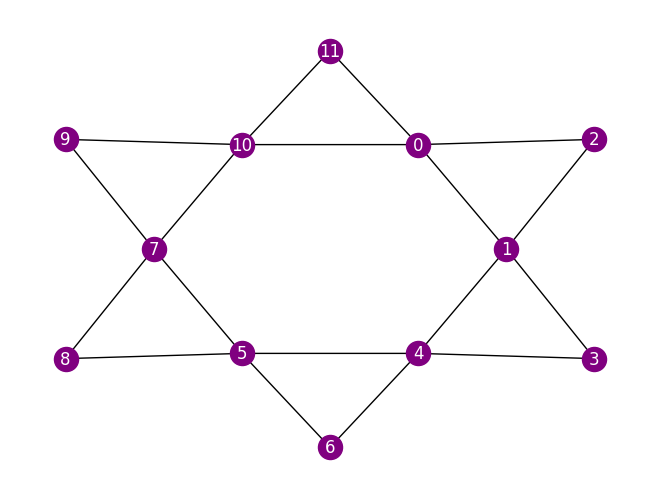

In [5]:
cell_12 = kagome.create_lattice(12,edges_12)
kagome.draw_lattice(cell_12,pos12)

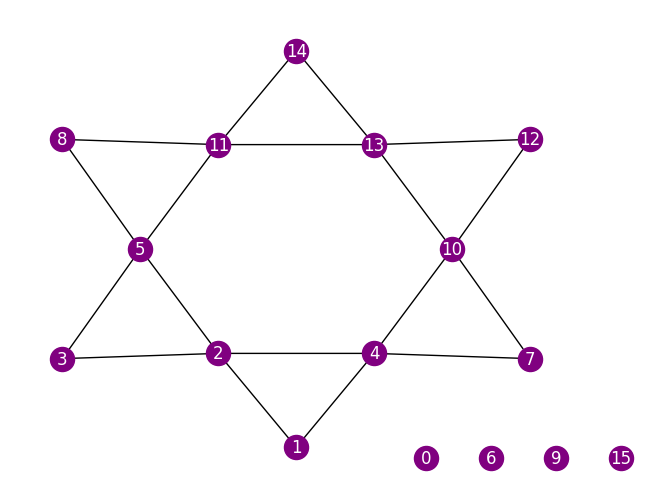

In [6]:
cell_16 = kagome.create_lattice(16,edges_16)
kagome.draw_lattice(cell_16,pos16)

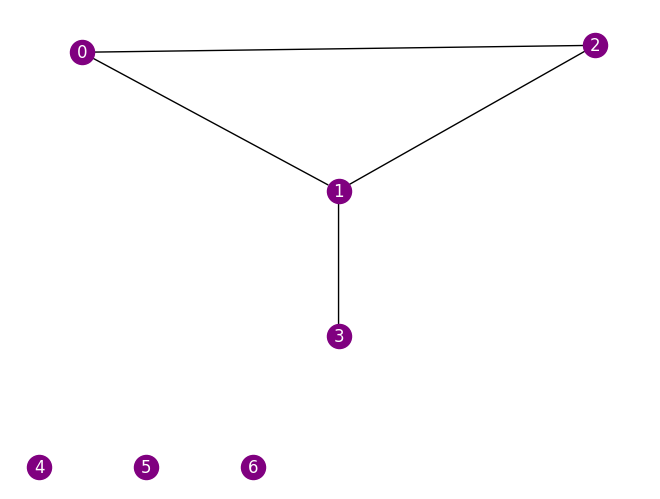

In [7]:
cell_7 = kagome.create_lattice(7,edges_4)
kagome.draw_lattice(cell_7,pos7)

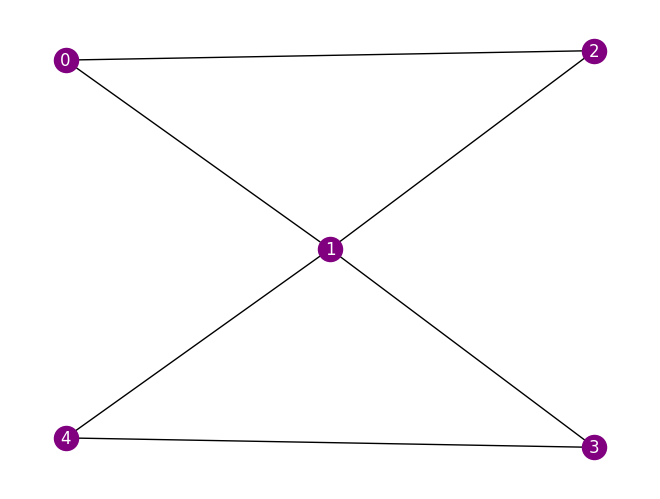

In [8]:
cell_5 = kagome.create_lattice(5,edges_5)
kagome.draw_lattice(cell_5,pos5)

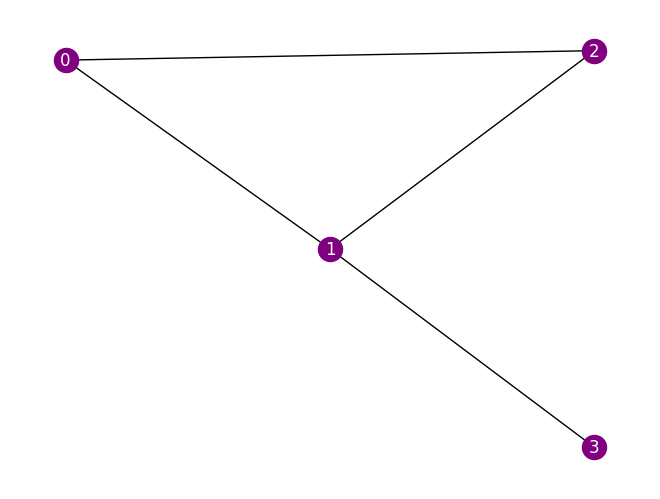

In [9]:
cell_4 = kagome.create_lattice(4,edges_4)
kagome.draw_lattice(cell_4,pos4)

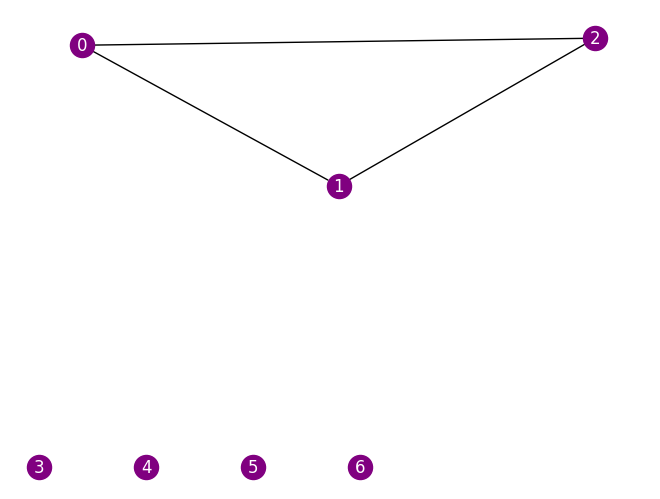

In [61]:
cell_3 = kagome.create_lattice(7,edges_3)
kagome.draw_lattice(cell_3,pos3)

## Build Hamiltonians

In [66]:
H12 = kagome.get_hamiltonian(cell_12)
H16 = kagome.get_hamiltonian(cell_16)
H7  = kagome.get_hamiltonian(cell_7)
H4  = kagome.get_hamiltonian(cell_4)
H3  = kagome.get_hamiltonian(cell_3)

kagome.SparsePauliPrint(H3.primitive)

Sparse Pauli(128, 128) as list:
1:	IIIIZZI * (1+0j)
2:	IIIIZIZ * (1+0j)
3:	IIIIIZZ * (1+0j)
4:	IIIIYYI * (1+0j)
5:	IIIIYIY * (1+0j)
6:	IIIIIYY * (1+0j)
7:	IIIIXXI * (1+0j)
8:	IIIIXIX * (1+0j)
9:	IIIIIXX * (1+0j)




## Initial Ansatzs

In [63]:
A3_SU2 = EfficientSU2(3, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
A3_SU2_opt = transpile(A3_SU2, backend=nairobi, initial_layout=qbitmap_3_to_7)
print(f"A3_SU2_opt param count {A3_SU2_opt.num_parameters}; gates:{A3_SU2_opt.count_ops()}")


A4_SU2 = EfficientSU2(4, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
A4_SU2_opt = transpile(A4_SU2, backend=nairobi, initial_layout=qbitmap_4_to_7)
print(f"A4_SU2_opt param count {A4_SU2_opt.num_parameters}; gates:{A4_SU2_opt.count_ops()}")


A12_SU2 = EfficientSU2(12, entanglement='linear', reps=3, skip_final_rotation_layer=True).decompose()
A12_SU2_opt = transpile(A12_SU2, backend=guadalupeSim, initial_layout=qbitmap_12_to_16)
print(f"A12_SU2_opt param count {A12_SU2_opt.num_parameters}; gates:{A12_SU2_opt.count_ops()}")


A3_SU2_opt param count 18; gates:OrderedDict([('rz', 27), ('sx', 18), ('cx', 6)])
A4_SU2_opt param count 24; gates:OrderedDict([('rz', 36), ('sx', 24), ('cx', 18)])
A12_SU2_opt param count 72; gates:OrderedDict([('rz', 108), ('sx', 72), ('cx', 33)])


A3_cust1_opt  param count 6; gates:OrderedDict([('rz', 13), ('sx', 8), ('cx', 3)])
A4_cust1_opt  param count 8; gates:OrderedDict([('rz', 16), ('sx', 10), ('cx', 8)])
A12_cust1_opt param count 24; gates:OrderedDict([('rz', 48), ('sx', 30), ('cx', 17)])


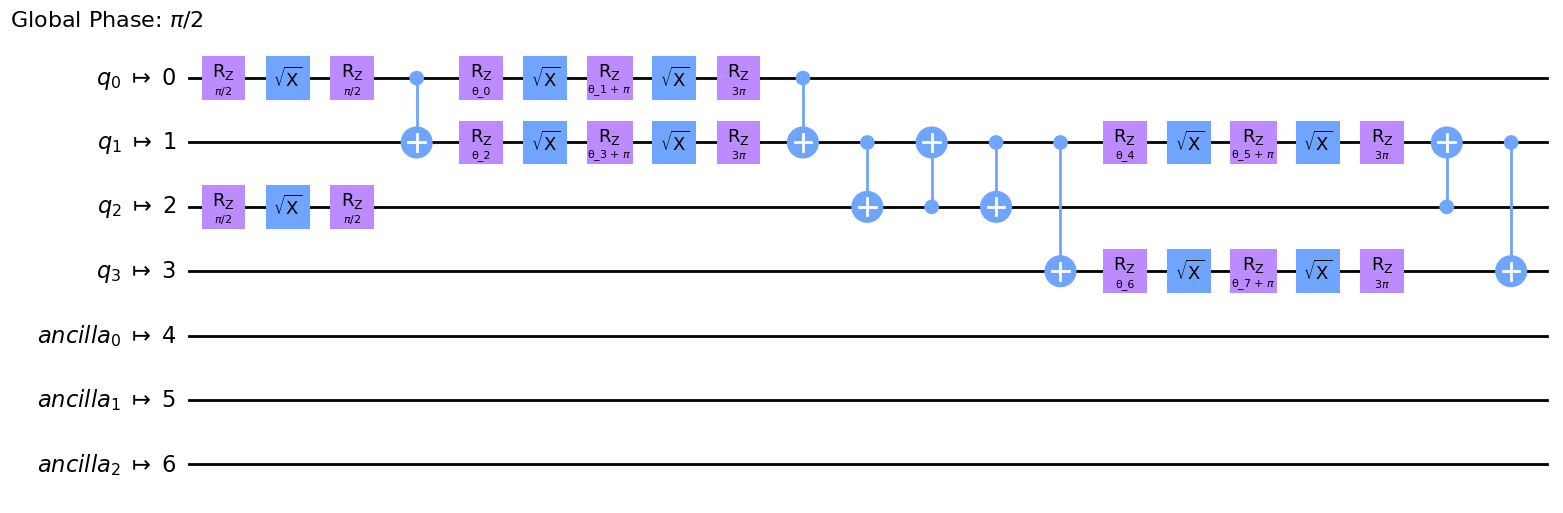

In [64]:
# Build a custom ansatz from scratch
def customAnsatz1(num_qubits):
    from qiskit.circuit import Parameter
    ansatz_custom = QuantumCircuit(num_qubits)
    # build initial state
    ansatz_custom.h(range(0, num_qubits, 2))
    ansatz_custom.cx(range(0, num_qubits-1, 2), range(1, num_qubits, 2))
    # First layer
    j = 0
    for i in range(num_qubits):
        ansatz_custom.rz(Parameter('θ_' + str(j)), i)
        j += 1
        ansatz_custom.ry(Parameter('θ_' + str(j)), i)
        j += 1
    ansatz_custom.cx(range(0, num_qubits-1), range(1, num_qubits))
    return ansatz_custom

A3_cust1  = customAnsatz1(3)
A3_cust1_opt = transpile(A3_cust1, backend=nairobi, initial_layout=qbitmap_3_to_7)

A4_cust1  = customAnsatz1(4)
A4_cust1_opt = transpile(A4_cust1, backend=nairobi, initial_layout=qbitmap_4_to_7)

A12_cust1 = customAnsatz1(12)
A12_cust1_opt = transpile(A12_cust1, backend=guadalupeSim, initial_layout=qbitmap_12_to_16)
print(f"A3_cust1_opt  param count {A3_cust1_opt.num_parameters}; gates:{A3_cust1_opt.count_ops()}")
print(f"A4_cust1_opt  param count {A4_cust1_opt.num_parameters}; gates:{A4_cust1_opt.count_ops()}")
print(f"A12_cust1_opt param count {A12_cust1_opt.num_parameters}; gates:{A12_cust1_opt.count_ops()}")

A4_cust1_opt.draw()

## Compute Exact Solutions for Reference

In [14]:
from qiskit.algorithms import NumPyEigensolver

exact_result3  = NumPyEigensolver(k=20).compute_eigenvalues(H3)
exact_result4  = NumPyEigensolver(k=20).compute_eigenvalues(H4)
exact_result12 = NumPyEigensolver(k=3).compute_eigenvalues(H12)

print(f"Mini Lattice (3 Nodes) eigenvalues {exact_result3.eigenvalues}")
print(f"Part Lattice (4 Nodes) eigenvalues {exact_result4.eigenvalues}")
print(f"Full Lattice (12 Nodes) eigenvalues {exact_result12.eigenvalues}")

targets = {3:exact_result3.eigenvalues[0],
           4:exact_result4.eigenvalues[0],
           12:exact_result12.eigenvalues[0],
          }

Mini Lattice (3 Nodes) eigenvalues [-3. -3. -3. -3.  3.  3.  3.  3.]
Part Lattice (4 Nodes) eigenvalues [-6. -4. -4. -4. -2. -2. -2. -2.  2.  2.  2.  4.  4.  4.  4.  4.]
Full Lattice (12 Nodes) eigenvalues [-18.         -18.         -16.96132284]


# Develop Sub-lattice
### Consider the lattice consisting of Nodes 0, 1, 2, and 3

* The full lattice can be built three (3) copies of this sub-lattice
* Nodes 0, 4, and 7, the starting corners of each sub-lattice
* Impose boundary conditions between 0 <-> 4 <-> 7 <-> 0
* Solve the energy level of the sub-lattice 0 thru 4 (5 nodes)
   * Use 4 nodes (0-3)
   * Boundary conditions to map H entries from 1<->4 and 3<->4

# Boundary Conditions

Node 4 is  related to Node 0 such that

$$
    \psi_4  =K*\psi_0  \\
    K^3 = I
$$

Assuming symetric rotations around the lattice we have

$$  
   K_i =R_x(\theta_i)*R_y(\phi_i)*R_z(\lambda_i) \\ i\in [0,1,2]  \\
   \sum_{i=0}^2\theta_i = n*2\pi \quad n \in I \\
   \sum_{i=0}^2\phi_i = n*2\pi  \\
   \sum_{i=0}^2\lambda_i = n*2\pi  \\
$$
 
Simple starting points are

$$  
\begin{equation}
(1) \quad \theta_i = \phi_i = \lambda_i = 0  \\
(2) \quad \theta_i = \phi_i = \lambda_i = \frac{2\pi}{3}  \\
(3) \quad \theta_i = \phi_i = \lambda_i = \frac{4\pi}{3}  \label{eq1} \\
\end{equation}
$$

For case 1:
$$
K=I  \\
\psi_4 = \psi_0
$$

# Adding Boundary Conditions
## Add Hamiltonian entries on the boundary
Must add $XX + YY + ZZ$ on virtual edges of the sub-lattice for to Node 4
$$\psi_1 \psi_4 = \psi_1\psi_0 + \psi_1 (K*\psi_0) \\
\psi_3 \psi_4 = \psi_3 (K\psi_0) $$
For case 1, $K=I$ the additional Hamiltonian entries are:

\begin{align}
H_{case1} =~~ &1.0*(IIZZ+IIYY+IIXX)~~ + \\ &1.0*(ZIIZ+YIIY+XIIX) 
\end{align}


In [15]:
# Create the addtional terms for the Case 1 Hamiltonian
from qiskit.opflow import X, Y, Z, I
# H1_1_4 = 1.0*(I^I^Z^Z) + 1.0*(I^I^Y^Y) + 1.0*(I^I^X^X)

def BoundaryCondition(qbits,K,num_qubits):
    from qiskit.quantum_info import SparsePauliOp
    from qiskit.opflow.primitive_ops import PauliSumOp
    # Start with K = I
    coefs = [1.0, 1.0, 1.0]
    op = SparsePauliOp.from_sparse_list([("XX", qbits, coefs[0]), 
                                         ("YY", qbits, coefs[1]),
                                         ("ZZ", qbits, coefs[2])] ,num_qubits=num_qubits)
    H = PauliSumOp(op)
    return H

### H4_BC_1  -  4 Node, Case 1 Boundary Condition: K = I

In [16]:
# Case 1  K = I
H4_BCS_C1 = BoundaryCondition([0,1],I,4) + BoundaryCondition([0,3],I,4)
H4_full = H4 + H4_BCS_C1
H4_BC_1 = H4 + H4_BCS_C1
exact_result4_C1 = NumPyEigensolver(k=20).compute_eigenvalues(H4_BC_1)
targets['H4_BC_1'] = exact_result4_C1.eigenvalues[0]

# kagome.SparsePauliPrint(H4_BCS_C1.primitive,label='Additional Terms')
print(f"Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues {exact_result4_C1.eigenvalues}\n")
# kagome.SparsePauliPrint(H4_BC_1.primitive,label='Full Hamiltonian Case 1: K=I')

Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues [-6. -6. -6. -6. -6. -2. -2. -2.  2.  2.  2.  6.  6.  6.  6.  6.]



### H7_BC_1  -  4 Node, 7 Qubit - Case 1 Boundary Condition: K = I

In [17]:
H7_BCS_C1 = BoundaryCondition([0,1],I,7) + BoundaryCondition([3,0],I,7)
H7_BC_1 = H7 + H7_BCS_C1
exact_result7_C1 = NumPyEigensolver(k=20).compute_eigenvalues(H7_BC_1)
targets['H7_BC_1'] = exact_result4_C1.eigenvalues[0]

print(f"Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues {exact_result4_C1.eigenvalues}\n")
# kagome.SparsePauliPrint(H7_BC_1.primitive,label='7 Qubit - 4 Node - Full Hamiltonian Case 1')

Part Lattice (4 Nodes) Case 1 (K=I) eigenvalues [-6. -6. -6. -6. -6. -2. -2. -2.  2.  2.  2.  6.  6.  6.  6.  6.]



# Setup for Runs
## Data Files, Ansatz and Optimizers

In [ ]:
import importlib
importlib.reload(kagome)

In [18]:
# File Names
fnameFull     = 'FullLatticeResults.dump'
fnameSub      = 'SubLatticeResults.dump'

In [19]:
# Optimizers
from qiskit.algorithms.optimizers import SPSA
SPSA_01 = SPSA(maxiter=75)
SPSA_01_label = 'SPSA(75)'

# --------------------- Solutions -----------------------------

# Full Lattice - Local and Cloud

### Custom Ansatz

In [20]:
FullResults = kagome.load_customVQE(fnameFull)

Loaded 2 results


In [21]:
# Local Simulator
H = H16
target = -18.0
label = f"A12 Cust1 {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A12_cust1_opt, SPSA_01, 
                                 timeout=120, x0=None, target=target,
                                 service=None, backend=None, 
                                 resultsList=FullResults,
                                 label=label)
kagome.save_customVQE(FullResults,fnameFull)

A12 Cust1 SPSA(75) 2 Local SPSA
Runtime 23.96275 sec


0: 'A12 Cust1 SPSA(75) 0 Local SPSA' 	Computed: -6.501	Target:   -18.0	Error 63.884%
1: 'A12_SU2   SPSA(75) 1 Local SPSA' 	Computed: -8.409	Target:   -18	Error 53.286%
2: 'A12 Cust1 SPSA(75) 2 Local SPSA' 	Computed: -6.202	Target:   -18.0	Error 65.545%


Computed ground state energy: -6.2019401583
Expected ground state energy: -18.0000000000
Relative error: 65.5447769%


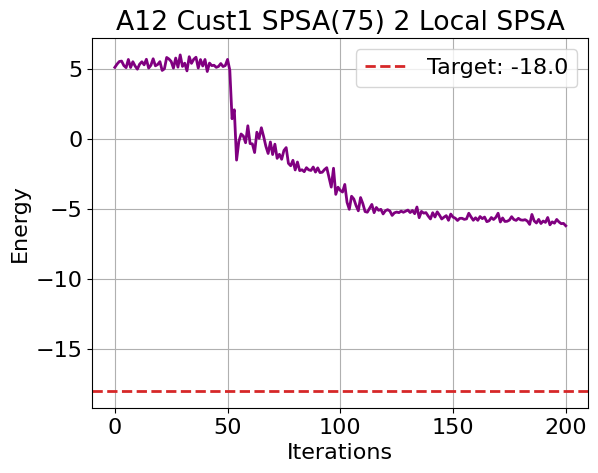

In [22]:
kagome.list_results(FullResults)
FullResults[-1].show_result()

### Efficient SU2 Ansatz

In [23]:
FullResults = kagome.load_customVQE(fnameFull)

Loaded 3 results


In [24]:
# Local Simulator
H = H16
target = -18.0
label = f"A12_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A12_SU2_opt, SPSA_01, 
                          service=None, backend=None, 
                          timeout=180, x0=None, target=-18,
                          resultsList=FullResults,
                          label=label )
kagome.save_customVQE(FullResults,fnameFull)

A12_SU2   SPSA(75) 3 Local SPSA
Runtime 44.38386 sec


In [ ]:
# Cloud Solver
H = H16
target = -18.0
label = f"A12_SU2   {SPSA_01_label}"
custom_vqe = runCustomVQE(H, A12_SU2_opt, SPSA_01,
                          service=service, backend='simulator_statevector',
                          timeout=180, x0=None, target=-18,
                          resultsList=FullResults,
                          label=label)
kagome.save_customVQE(FullResults,fnameFull)

0: 'A12 Cust1 SPSA(75) 0 Local SPSA' 	Computed: -6.501	Target:   -18.0	Error 63.884%
1: 'A12_SU2   SPSA(75) 1 Local SPSA' 	Computed: -8.409	Target:   -18	Error 53.286%
2: 'A12 Cust1 SPSA(75) 2 Local SPSA' 	Computed: -6.202	Target:   -18.0	Error 65.545%
3: 'A12_SU2   SPSA(75) 3 Local SPSA' 	Computed: -9.369	Target:   -18	Error 47.95%


Computed ground state energy: -9.3689579892
Expected ground state energy: -18.0000000000
Relative error: 47.95023339%


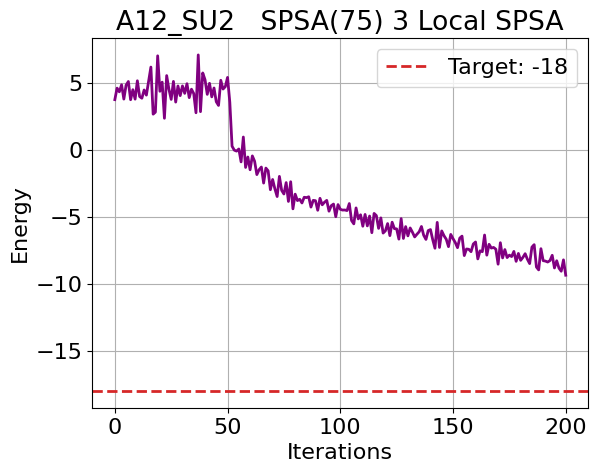

In [25]:
kagome.list_results(FullResults)
FullResults[-1].show_result()

# Sub-Lattice

### A3 SU2 - Local

In [41]:
SubResults = kagome.load_customVQE(fnameSub)

Loaded 4 results


In [83]:
# Local Simulation
H = H3
target = targets[3]
label = f"A3_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A3_SU2_opt, SPSA_01, 
                          timeout=180, x0=None, target=target,
                          service=None, backend=None,
                          resultsList=SubResults,
                          label=label )
kagome.save_customVQE(SubResults,fnameSub)

A3_SU2   SPSA(75) 13 Local SPSA
Runtime 0.97603 sec


In [74]:
# Local Simulation
H = H3
target = targets[3]
label = f"A3_cust1 {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A3_cust1_opt, SPSA_01, 
                          timeout=180, x0=None, target=target,
                          service=None, backend=None,
                          resultsList=SubResults,
                          label=label )
kagome.save_customVQE(SubResults,fnameSub)

A3_cust1 SPSA(75) 10 Local SPSA
Runtime 0.6843 sec


0: 'A4_cust1 SPSA(75) 0 Local SPSA' 	Computed: -2.245	Target:   -6	Error 62.585%
1: 'A4_SU2   SPSA(75) 1 Local SPSA' 	Computed: -3.475	Target:   -6	Error 42.077%
2: 'A4_cust1 SPSA(75) 2 Local SPSA' 	Computed: -2.247	Target:   -6	Error 62.554%
3: 'A4_SU2   SPSA(75) 3 Local SPSA' 	Computed: -5.154	Target:   -6	Error 14.099%
4: 'A3_SU2 SPSA(75) 4 Local SPSA' 	Computed: -2.96	Target:   -6	Error 50.661%
5: 'A3_SU2   SPSA(75) 5 Local SPSA' 	Computed: -2.937	Target:   -6	Error 51.049%
6: 'A3_SU2   SPSA(75) 6 Local SPSA' 	Computed: -2.979	Target:   -6	Error 50.345%
7: 'A3_SU2   SPSA(75) 7 Local SPSA' 	Computed: -2.949	Target:   -6	Error 50.849%
8: 'A3_cust1 SPSA(75) 8 Local SPSA' 	Computed: -1.732	Target:   -6	Error 71.136%
9: 'A3_SU2   SPSA(75) 9 Local SPSA' 	Computed: -2.958	Target:   -3.0	Error 1.409%
10: 'A3_cust1 SPSA(75) 10 Local SPSA' 	Computed: -1.731	Target:   -3.0	Error 42.3%
11: 'A4_cust1 SPSA(75) 11 Local SPSA' 	Computed: -2.219	Target:   -6.0	Error 63.023%
12: 'A4_SU2   SPSA(75) 1

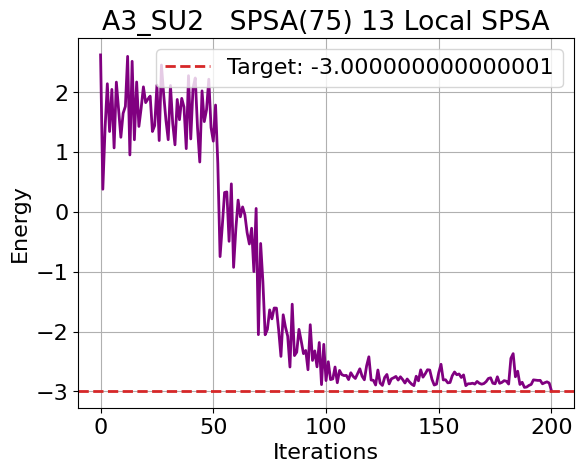

In [84]:
kagome.list_results(SubResults)
SubResults[-1].show_result()

### A4 Custom Ansatz - Local

In [26]:
SubResults = kagome.load_customVQE(fnameSub)

Loaded 2 results


In [78]:
# Local Simulation
H = H7_BC_1
target = targets[4]
label = f"A4_cust1 {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A4_cust1_opt, SPSA_01, 
                          timeout=180, x0=None, target=target,
                          service=None, backend=None,
                          resultsList=SubResults,
                          label=label )
kagome.save_customVQE(SubResults,fnameSub)

A4_cust1 SPSA(75) 11 Local SPSA
Runtime 0.90981 sec


0: 'A4_cust1 SPSA(75) 0 Local SPSA' 	Computed: -2.245	Target:   -6	Error 62.585%
1: 'A4_SU2   SPSA(75) 1 Local SPSA' 	Computed: -3.475	Target:   -6	Error 42.077%
2: 'A4_cust1 SPSA(75) 2 Local SPSA' 	Computed: -2.247	Target:   -6	Error 62.554%
3: 'A4_SU2   SPSA(75) 3 Local SPSA' 	Computed: -5.154	Target:   -6	Error 14.099%
4: 'A3_SU2 SPSA(75) 4 Local SPSA' 	Computed: -2.96	Target:   -6	Error 50.661%
5: 'A3_SU2   SPSA(75) 5 Local SPSA' 	Computed: -2.937	Target:   -6	Error 51.049%
6: 'A3_SU2   SPSA(75) 6 Local SPSA' 	Computed: -2.979	Target:   -6	Error 50.345%
7: 'A3_SU2   SPSA(75) 7 Local SPSA' 	Computed: -2.949	Target:   -6	Error 50.849%
8: 'A3_cust1 SPSA(75) 8 Local SPSA' 	Computed: -1.732	Target:   -6	Error 71.136%
9: 'A3_SU2   SPSA(75) 9 Local SPSA' 	Computed: -2.958	Target:   -3.0	Error 1.409%
10: 'A3_cust1 SPSA(75) 10 Local SPSA' 	Computed: -1.731	Target:   -3.0	Error 42.3%
11: 'A4_cust1 SPSA(75) 11 Local SPSA' 	Computed: -2.219	Target:   -6.0	Error 63.023%


Computed ground state 

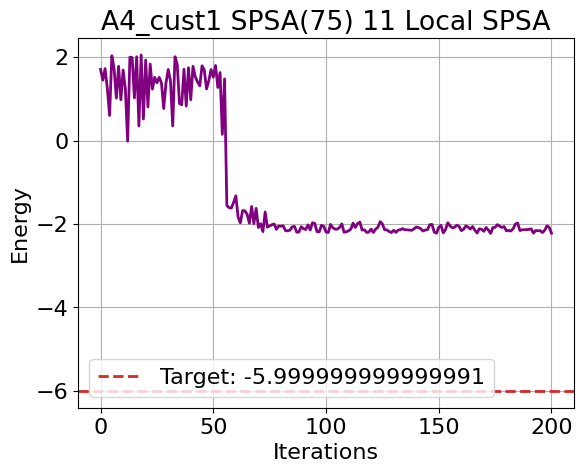

In [79]:
kagome.list_results(SubResults)
SubResults[-1].show_result()

### Efficient SU2 Ansatz - Local

In [29]:
SubResults = kagome.load_customVQE(fnameSub)

Loaded 3 results


In [81]:
# Local Simulation
H = H7
target = targets[4]
label =f"A4_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A4_SU2_opt, SPSA_01, 
                          timeout=180, x0=None, target=target,
                          service=None, backend=None, 
                          resultsList=SubResults,
                          label=label)
kagome.save_customVQE(SubResults,fnameSub)

A4_SU2   SPSA(75) 12 Local SPSA
Runtime 1.50536 sec


0: 'A4_cust1 SPSA(75) 0 Local SPSA' 	Computed: -2.245	Target:   -6	Error 62.585%
1: 'A4_SU2   SPSA(75) 1 Local SPSA' 	Computed: -3.475	Target:   -6	Error 42.077%
2: 'A4_cust1 SPSA(75) 2 Local SPSA' 	Computed: -2.247	Target:   -6	Error 62.554%
3: 'A4_SU2   SPSA(75) 3 Local SPSA' 	Computed: -5.154	Target:   -6	Error 14.099%
4: 'A3_SU2 SPSA(75) 4 Local SPSA' 	Computed: -2.96	Target:   -6	Error 50.661%
5: 'A3_SU2   SPSA(75) 5 Local SPSA' 	Computed: -2.937	Target:   -6	Error 51.049%
6: 'A3_SU2   SPSA(75) 6 Local SPSA' 	Computed: -2.979	Target:   -6	Error 50.345%
7: 'A3_SU2   SPSA(75) 7 Local SPSA' 	Computed: -2.949	Target:   -6	Error 50.849%
8: 'A3_cust1 SPSA(75) 8 Local SPSA' 	Computed: -1.732	Target:   -6	Error 71.136%
9: 'A3_SU2   SPSA(75) 9 Local SPSA' 	Computed: -2.958	Target:   -3.0	Error 1.409%
10: 'A3_cust1 SPSA(75) 10 Local SPSA' 	Computed: -1.731	Target:   -3.0	Error 42.3%
11: 'A4_cust1 SPSA(75) 11 Local SPSA' 	Computed: -2.219	Target:   -6.0	Error 63.023%
12: 'A4_SU2   SPSA(75) 1

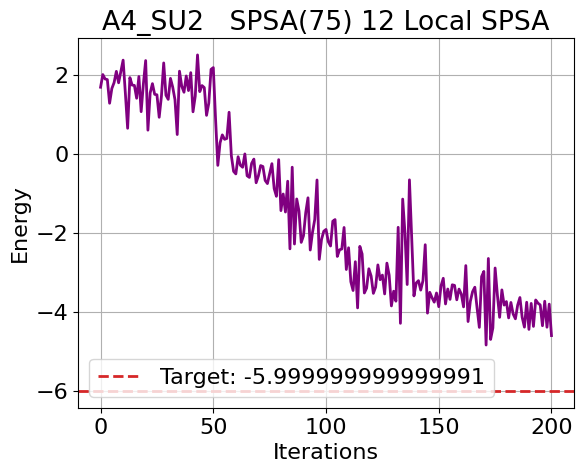

In [82]:
kagome.list_results(SubResults)
SubResults[-1].show_result()

## Efficient SU2 - Cloud

In [ ]:
SubResults = kagome.load_customVQE(fnameSub)

In [ ]:
# Cloud Solution
H = H7
target = targets[4]
label =f"A4_SU2   {SPSA_01_label}"
custom_vqe = kagome.runCustomVQE(H, A4_SU2_opt, SPSA_01, 
                          service=service, backend='simulator_statevector', 
                          timeout=180, x0=None, target=target,
                          resultsList=SubResults,
                          label=label)
kagome.save_customVQE(SubResults,fnameSub)

In [ ]:
kagome.list_results(SubResults)
SubResults[4].show_result()

# Build Ansantz Starting Point

In [ ]:
SubResults[0]._circuit.draw('latex')

In [32]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_bloch_multivector

def VQE2Statevector(custom_vqe):
    from qiskit import Aer
    sim = Aer.get_backend('aer_simulator')
    qc = custom_vqe._circuit.assign_parameters(custom_vqe._result.optimal_parameters)
    qc.save_statevector()
    result = sim.run(qc).result()
    state_vector = result.get_statevector()
    return state_vector

def getBlochCoords(state_vector,qubit):
    num_qubits = len(state_vector.dims())
    if qubit >= num_qubits:
        return None

    from qiskit.quantum_info import SparsePauliOp
    Xop = SparsePauliOp.from_sparse_list([("X", [qubit], 1)], num_qubits=num_qubits)
    Yop = SparsePauliOp.from_sparse_list([("Y", [qubit], 1)], num_qubits=num_qubits)
    Zop = SparsePauliOp.from_sparse_list([("Z", [qubit], 1)], num_qubits=num_qubits)
    x = state_vector.expectation_value(Xop)
    y = state_vector.expectation_value(Yop)
    z = state_vector.expectation_value(Zop)
    return [x,y,z]

def getBlochAngles(state_vector):
    angles = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords = getBlochCoords(state_vector,qbit)
        (r,theta,phi) = cart2bloch(coords)
        angles.append([theta,phi])
    return angles

def getCoords(state_vector):
    coords = []
    num_qubits = len(state_vector.dims())
    for qbit in range(num_qubits):
        coords.append(getBlochCoords(state_vector,qbit))
    return coords

def cart2bloch(pt):
    (x,y,z) = np.real(pt)
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy,z)
    phi = np.arctan2(y, x)
    return r, theta, phi

def bloch2cart(pt):
    (r,theta,phi) = np.real(pt)
    xy = r*np.sin(theta)
    x  = xy*np.cos(phi)
    y  = xy*np.sin(phi)
    z  = r*np.cos(theta)
    return x, y, z

def bloch2circuit(angles,nqubits):
    qc = QuantumCircuit(nqubits)
    if len(angles) < nqubits:
        nqubits = len(angles)
    for nbit in range(nqubits):
        (theta, phi) = angles[nbit]
        qc.ry(theta,nbit)
        qc.rz(phi,nbit)
    return qc

def bloch2Statevector(angles,nqubits=None):
    if nqubits is None:
        nqubits = len(angles)
    qc = bloch2circuit(angles,nqubits)
    return Statevector(qc)

def getNormedState(custom_vqe,nqubits=None):
    init_svector = VQE2Statevector(custom_vqe)
    angles = getBlochAngles(init_svector)
    normed_svector = bloch2Statevector(angles,nqubits=nqubits)
    return normed_svector


In [ ]:
import jTools
jTools.cellOutputAll()

In [33]:
def displayNormedData(custom_vqe,H,nqubits=None):
    svector = VQE2Statevector(custom_vqe)
    expSvector = np.real(svector.expectation_value(H))
    normed_svector = getNormedState(custom_vqe)
    coords = np.real(getCoords(normed_svector))
    expNormed = np.real(normed_svector.expectation_value(H))

    print(f"{myList[idx].label}: {np.around(expSvector,5)} Initial State Energy Level")
    print("---------------------")
    print(f"{myList[idx].label}: {np.around(expNormed,5)} Normalized State Energy Level")

    return plot_bloch_multivector(getNormedState(myList[idx],nqubits=nqubits))

In [85]:
SubResults = kagome.load_customVQE(fnameSub)

Loaded 14 results


A3_SU2   SPSA(75) 13 Local SPSA: -2.99049 Initial State Energy Level
---------------------
A3_SU2   SPSA(75) 13 Local SPSA: 1.93274 Normalized State Energy Level


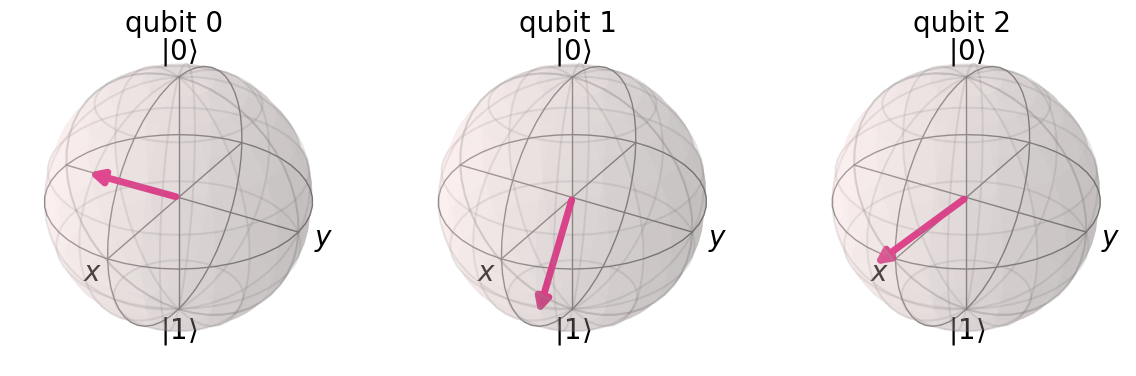

In [88]:
idx = -1
myList = SubResults
displayNormedData(myList[idx],H3,nqubits=3)